In [1]:
from datasets import load_dataset

/Users/jaycui/shilongjaycui/emotion-classifier/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset('emotion')

/Users/jaycui/shilongjaycui/emotion-classifier/venv/lib/python3.10/site-packages/datasets/load.py:1454: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [3]:
import pandas as pd

pd.set_option('display.max_colwidth', None)  # Show full column width

In [4]:
from pandas import DataFrame

train_dataset = dataset['train']
train_df: DataFrame = dataset["train"].to_pandas()
train_df.sample(n=5)

,text,label
139,i don t know why perhaps because other girls in the office had nice short hair or perhaps i was just feeling rebellious,3
1214,i feel completely drained physically and mentally worn out,0
7570,im feeling quite disillusioned about my weighins,0
7121,i feel invigorated and energized and ready to go out and save the world,1
6775,i have a feeling david is going to turn out to be a terrific father hes already exposing his newborn son to the world of the geek,1


In [5]:
from typing import Dict

emotion_dict: Dict[int, str] = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise',
}

train_df_copy = train_df.copy(deep=True)
train_df_copy['emotion'] = train_df_copy['label'].apply(lambda index: emotion_dict[index])
train_df_copy = train_df_copy[['text', 'emotion']]
train_df_copy

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplace i will know that it is still on the property,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag and i said to anna that i feel like i have been beaten up,sadness
15996,i am now turning and i feel pathetic that i am still waiting tables and subbing with a teaching degree,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and im glad that t,anger


In [6]:
from pandas import Series

X: Series = train_df['text']
y: Series = train_df['label']

print(f'X.shape: {X.shape}')
print(f'X: {X.tolist()[:5]}')

print(f'\ny.shape: {y.shape}')
print(f'y: {y.tolist()[:5]}')

X.shape: (16000,)
X: ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']

y.shape: (16000,)
y: [0, 0, 3, 2, 3]


In [7]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

In [8]:
# Creating the pipeline
model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier())
])

In [9]:
model.fit(X, y)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', RandomForestClassifier())])

In [10]:
from sklearn.metrics import accuracy_score, classification_report
from typing import List

print(dataset.column_names)

# For a classification task
X_test: List = dataset['test']['text']
y_test: List = dataset['test']['label']

y_pred = model.predict(X=X_test)  # predict the actual class
print("Accuracy:", accuracy_score(y_true=y_test, y_pred=y_pred))
print(classification_report(y_test, y_pred))

{'train': ['text', 'label'], 'validation': ['text', 'label'], 'test': ['text', 'label']}
Accuracy: 0.8635
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       581
           1       0.83      0.94      0.89       695
           2       0.80      0.62      0.70       159
           3       0.90      0.82      0.86       275
           4       0.84      0.83      0.84       224
           5       0.64      0.55      0.59        66

    accuracy                           0.86      2000
   macro avg       0.83      0.78      0.80      2000
weighted avg       0.86      0.86      0.86      2000



Create a precision-recall curve.

In [11]:
# Get predicted probabilities for the positive class
y_scores = model.predict_proba(X=X_test)  # predict the class probabilities
print(f'y_scores:\n{y_scores}\n')
print(f'y_scores.shape: {y_scores.shape}')

y_scores:
[[0.64       0.2        0.04       0.04       0.08       0.        ]
 [0.91       0.04       0.01       0.04       0.         0.        ]
 [0.69       0.21       0.02       0.035      0.045      0.        ]
 ...
 [0.11       0.76       0.03       0.04       0.06       0.        ]
 [0.17       0.67       0.05       0.04       0.07       0.        ]
 [0.14       0.11       0.02       0.03       0.42666667 0.27333333]]

y_scores.shape: (2000, 6)


In [12]:
from sklearn.metrics import precision_recall_curve

# Compute precision-recall curve values
try:
    precision, recall, _ = precision_recall_curve(y_true=y_test, probas_pred=y_scores)
except ValueError:
    print('`precision_recall_curve` is designed for binary classification problems.')
    print('''ChatGPT: While precision-recall curves are commonly associated with binary
          classification problems, they can be extended to multi-class scenarios by
          considering each class as a separate binary classification problem.''')

`precision_recall_curve` is designed for binary classification problems.
ChatGPT: While precision-recall curves are commonly associated with binary
          classification problems, they can be extended to multi-class scenarios by
          considering each class as a separate binary classification problem.


In [13]:
from sklearn.metrics import auc
from numpy import ndarray
import numpy as np

# Compute precision-recall curves for each class
precision_dict: Dict = {}
recall_dict: Dict = {}
average_precision: Dict = {}

# Loop through each class
for i in range(len(model.classes_)):
    # Compute precision-recall curve
    y_test: ndarray = np.array(y_test)
    precision_dict[i], recall_dict[i], _ = precision_recall_curve(y_test == i, y_scores[:, i])

    # Compute area under the curve (AUC) for precision-recall curve
    average_precision[i] = auc(recall_dict[i], precision_dict[i])

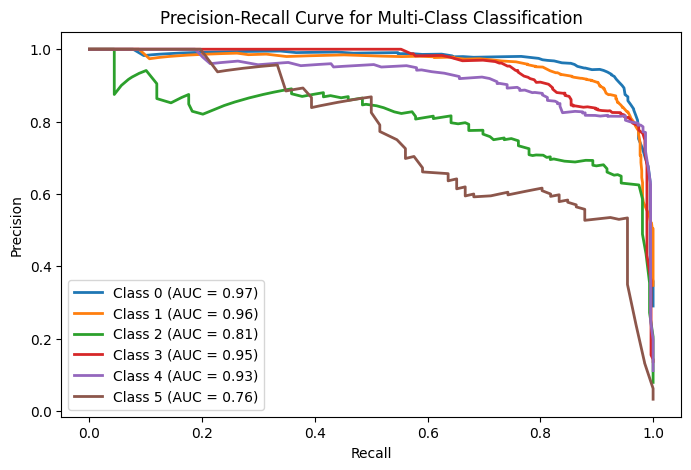

In [14]:
import matplotlib.pyplot as plt

# Plot the precision-recall curves for each class
plt.figure(figsize=(8, 5))
for i in range(len(model.classes_)):
    plt.plot(
        recall_dict[i],
        precision_dict[i],
        lw=2,
        label=f'Class {i} (AUC = {average_precision[i]:.2f})',
    )

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multi-Class Classification')
plt.legend(loc='best')
plt.show()

Create a confusion matrix.

In [15]:
from sklearn.metrics import confusion_matrix

conf_matrix: ndarray = confusion_matrix(y_true=y_test, y_pred=y_pred)

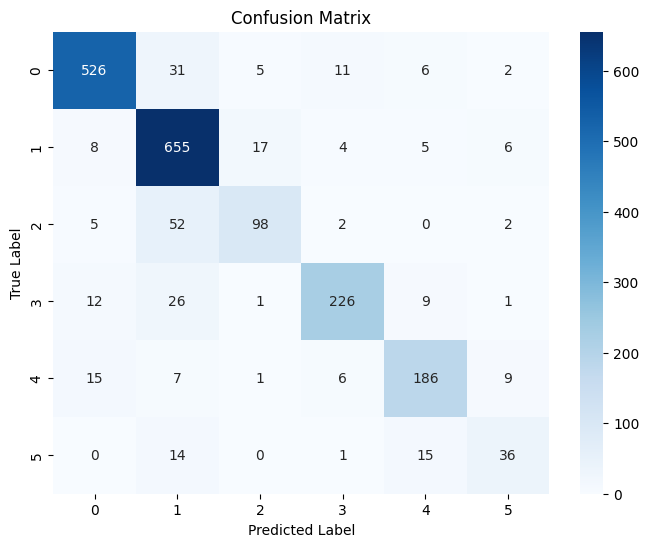

In [16]:
import seaborn as sns

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=model.classes_,
            yticklabels=model.classes_,
)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Examine false positives and false negatives.

In [17]:
print(f'# sentences: {len(X_test)}')
print(f'# predicted labels: {len(y_pred)}')
print(f'# actual labels: {len(y_test)}')

test_df: DataFrame = DataFrame({
    'text': X_test,
    'predicted label': y_pred,
    'actual label': y_test,
})
misclassifications = test_df[test_df['predicted label'] != test_df['actual label']]
misclassifications

# sentences: 2000
# predicted labels: 2000
# actual labels: 2000


,text,predicted label,actual label
6,i felt anger when at the end of a telephone call,1,3
10,i don t feel particularly agitated,3,4
12,i pay attention it deepens into a feeling of being invaded and helpless,0,4
36,i feel very honoured to be included in a magzine which prioritises health and clean living so highly im curious do any of you read magazines concerned with health and clean lifestyles such as the green parent,5,1
55,i have tried to see what it would be like if i liked one of my girl friends but it has never really worked and i can only ever feel an emotional connection to them because they are my friends,2,0
...,...,...,...
1957,i am feeling amazing and seeing the difference,1,5
1959,i check you when you re sleeping feel your nose and toes to be sure you aren t too hot or cold,3,1
1967,i see how it turns out i ll talk more about it right now i m feeling proud and scared and a little sick i think that s adrenaline though,4,1
1979,i have no strong feelings for this book neither hated nor loved it,0,3


In [18]:
print(f'labels: {emotion_dict}')

labels: {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}


false positives:

In [20]:
for encoding in emotion_dict:
    emotion = emotion_dict[encoding]
    false_positives = misclassifications[misclassifications['predicted label'] == encoding]
    print(f'\n# of sentences falsely classified to contain {emotion}: {len(false_positives)}')
    
    sample_size = min(len(false_positives), 3)
    false_positives_sample = false_positives.sample(n=sample_size)

    fp_text = false_positives_sample['text'].to_list()
    fp_predicted_label = false_positives_sample['predicted label'].to_list()
    fp_actual_label = false_positives_sample['actual label'].to_list()
    for i in range(sample_size):
        print(f' - \"{fp_text[i]}\" (predicted emotion: {emotion_dict[fp_predicted_label[i]]}; actual emotion: {emotion_dict[fp_actual_label[i]]})')
    


# of sentences falsely classified to contain sadness: 40
 - "i just went about my script of would you like mustard or sauce with that and started to feel really startled" (predicted emotion: sadness; actual emotion: fear)
 - "i was stressed about my job search and apartment hunting and i was just feeling overwhelmed with everything that was going on" (predicted emotion: sadness; actual emotion: fear)
 - "i still feel confused and guilty about the whole thing" (predicted emotion: sadness; actual emotion: fear)

# of sentences falsely classified to contain joy: 130
 - "i hear someone say we should just let gardeners be let folks do whatever they want i feel pretty aggravated" (predicted emotion: joy; actual emotion: anger)
 - "i feel fucking woeful looking at the other girls" (predicted emotion: joy; actual emotion: sadness)
 - "i feel the vile rising in my throat flipping up the lid on the toilet to let it out" (predicted emotion: joy; actual emotion: anger)

# of sentences falsely cla

false negatives:

In [21]:
for encoding in emotion_dict:
    emotion = emotion_dict[encoding]
    false_negatives = misclassifications[misclassifications['actual label'] == encoding]
    print(f'\n# of sentences falsely classified to NOT contain {emotion}: {len(false_negatives)}')
    
    sample_size = min(len(false_negatives), 3)
    false_negatives_sample = false_negatives.sample(n=sample_size)

    fp_text = false_negatives_sample['text'].to_list()
    fp_predicted_label = false_negatives_sample['predicted label'].to_list()
    fp_actual_label = false_negatives_sample['actual label'].to_list()
    for i in range(sample_size):
        print(f' - \"{fp_text[i]}\" (predicted emotion: {emotion_dict[fp_predicted_label[i]]}; actual emotion: {emotion_dict[fp_actual_label[i]]})')
    


# of sentences falsely classified to NOT contain sadness: 55
 - "i started questioning god feeling worthless and even jealous of others that come by parenthood so easily" (predicted emotion: anger; actual emotion: sadness)
 - "i have to keep fighting for my life until i truly run out of fight and i ve been close enough to that twice to know a bit about what it feels like and we re not there yet no matter how despairing all this feels" (predicted emotion: joy; actual emotion: sadness)
 - "i hate these feelings in my heart i hate that work stressed me out i hate that cornelius wont let me get my way im frustrated lord" (predicted emotion: anger; actual emotion: sadness)

# of sentences falsely classified to NOT contain joy: 40
 - "i firmly believe that the only way to go about this craft is to write the book that you feel passionate about and not to worry about finding the book that the mass audience desires" (predicted emotion: love; actual emotion: joy)
 - "i feel watching him grow in